# Prueba 1 Machine Learning

## Análisis de Sentimientos de Twitter

Nombre: __Hugo Andrés Zúñiga Soto__

Profesor: Josué Fredes

Generación: __G4__

__Agradecimientos:__ Verónica Martinez y Alejandra Aravena por la colaboración durante el desarrollo.
___

## Preliminares

### Descripción del problema

Se presenta un problema de análisis de texto, donde se debe comprender el sentimiento asociado a un `twit`. Para esto utilizaremos una base de datos proveniente de _CrowdFlower_.

### Objetivos

El objetivo del problema es alcanzar el mayor desempeño posible en clasificar el sentimiento de un `twit` determinando si es positivo o negativo. Para esto se implementará un modelo de clasificación.

### Criterios de optimización

Dado que trabajamos con texto, se utilizará la siguiente estrategia:

* Preprocesamiento y refinación: 
    - Se transformará cada palabra del texto a lowercase.
    - Se utilizará stopwords utilizando la librería `nltk (Natural Language ToolKit)`.
    - Se utilizará el proceso de lemantización para reducir las palabras similares.
* Representación:
    - Se representará cada `twit` en una matriz que mostrará la cantidad de ocurrencias de cada palabra.

Para optimizar el desempeño se buscará encontrar la mejor combinación de hiperparámetros en los modelos a entrenar. Se utilizará el algoritmo Naive Bayes Multinomial.

### Métricas de desempeño

Dado que trabajaremos con modelos de clasificación utilizaremos Matriz de Confusión, ROC Curve, Precision, Recall y F1.

## Aspectos computacionales

### Módulos a implementar

Para resolver este problema se utilizarán las siguientes librerias:

* nltk
* sklearn.feature_extraction.text.CountVectorizer
* sklearn.feature_extraction.text.TfidfVectorizer
* sklearn.naive_bayes.BernoulliNB
* sklearn.preprocessing.LabelEncoder
* sklearn.model_selection.train_test_split

In [1]:
# importo las librerias base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# librerias para el refinamiento de los datos
import missingno as msng
import nltk
import random
import re

#fijo la semilla pseudoaleatoria
rand_seed = 16254

# evito warnings de deprecacion y otros
import warnings
warnings.simplefilter('ignore')

### Funciones generadas

Para el preprocesamiento, refinación y representación de los datos utilizaremos distintas funciones que nos permitirán reducir el espacio de exploración.

Las funciones implementadas serán:

* Refactorización variables categóricas
* Refinamiento de texto
* Descripción de atrinuto
* Inspeción vector objetivo

## Análisis Exploratorio

In [2]:
# importo los datos
df = pd.read_csv('text_emotion.csv')
df.sample(5)

tweet_id   sentiment       author  \
32504  1752321198  enthusiasm      leatron   
24997  1694977690       empty  daisygurl33   
17271  1965575905       empty      TanMatt   
29200  1751140241       worry       teph19   
35255  1753072218        love       jimzak   

                                                 content  
32504  Think i'm going to go down to the lobby in a w...  
24997               @toddcnichols ~Congratulations Daddy  
17271  Ugh sittin at work waiting for the carpets to ...  
29200                is ONLiNE  http://plurk.com/p/stjdg  
35255  @suppz yeah, but Mr. Mom's I would say, apprec...

In [3]:
# Reviso el volumen de datos
df.shape

(40000, 4)

In [4]:
# revisamos la naturaleza de los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


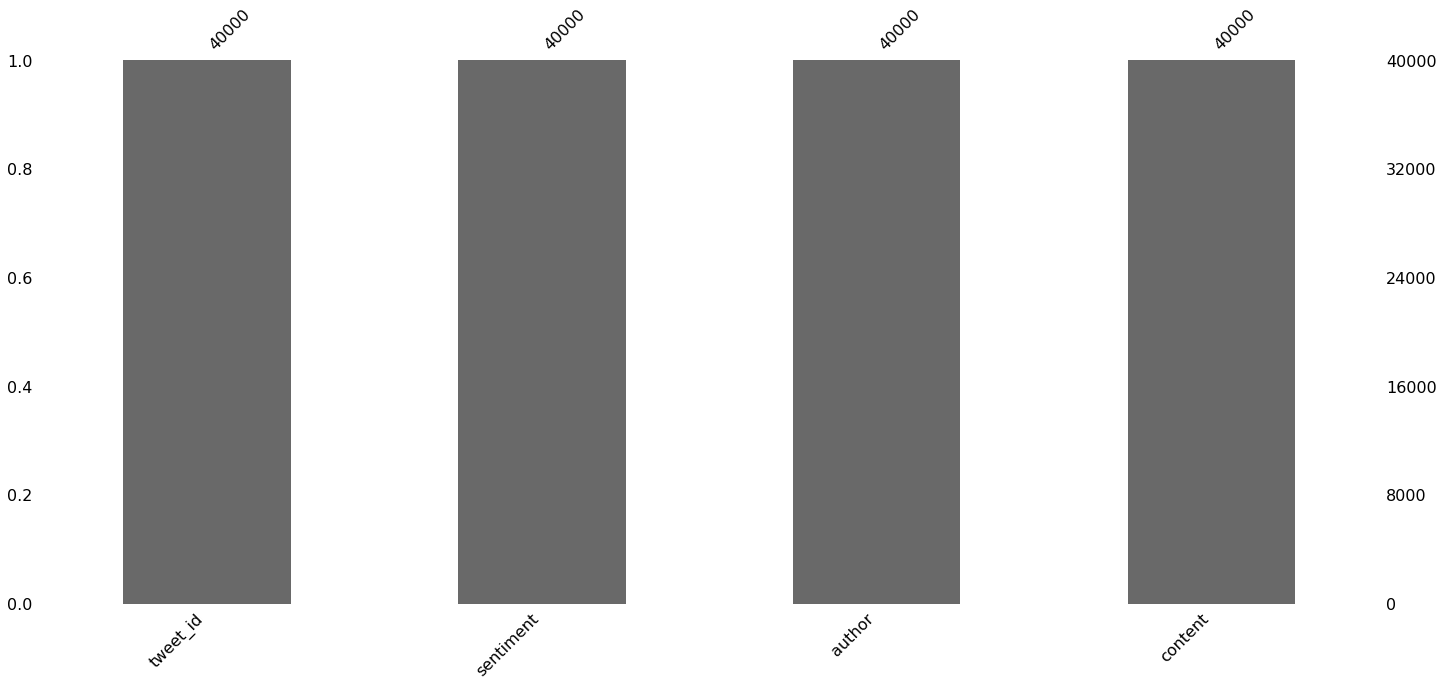

In [5]:
# reisamos si existen datos perdidos
msng.bar(df)

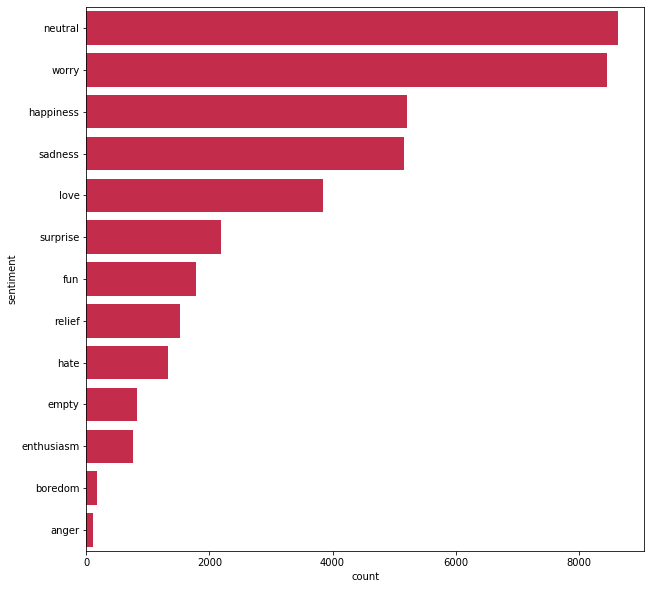

In [6]:
# revisamos el vector objetivo sentiment
plt.figure(figsize=(10,10))
sns.countplot(y=df['sentiment'], order = df['sentiment'].value_counts().index, color='crimson')

In [7]:
# para refinar los datos vamos a transformar los twits a lowercase
df['content'] = df['content'].str.lower()
df.sample(5)

tweet_id sentiment       author  \
28008  1696005184     empty       ahmier   
1654   1957363745      hate   teammartin   
17083  1965522878   sadness      Eggface   
34106  1752775640   neutral      bruwmac   
32493  1752320941   neutral  eric_merced   

                                                 content  
28008                            gooooood morning loves.  
1654   hates untalented bitches being mean to my tale...  
17083  @schatje ty. just a long tiring day filled wit...  
34106  @goodlaura trending you say? well, there's twe...  
32493   @dpocza i hope to take you on that offer one day

In [8]:
# refactorizaremos nuestro vector objetivo para obtener si el sentiemiento es positivo o negativo
df_obj = df['sentiment']
df_obj.sample(5)

1706       worry
39995    neutral
11280       hate
3728     neutral
36328    neutral
Name: sentiment, dtype: object

In [9]:
# utilizaremos la siguiente lista
sentiment = [('worry',-1),
             ('happiness',1),
             ('sadness',-1),
             ('love',1),
             ('surprise',1),
             ('fun',1),
             ('relief',1),
             ('hate',-1),
             ('empty',-1),
             ('enthusiasm',1),
             ('boredom',-1),
             ('anger',-1),
             ('neutral',0)]

In [10]:
# refactorizamos sentiment
df['sentiment_bin'] = df['sentiment']
for i in range(len(sentiment)):
    df['sentiment_bin'] = df['sentiment_bin'].replace(str(sentiment[i][0]),int(sentiment[i][1]))

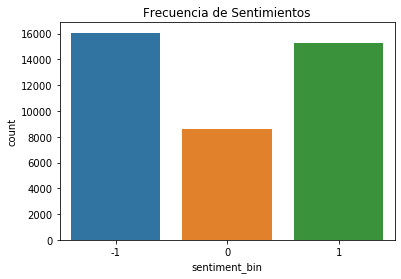

In [11]:
# Verificamos la frecuencia de los sentimientos 
sns.countplot(df['sentiment_bin'])
plt.title('Frecuencia de Sentimientos')
plt.show()

In [12]:
# Refactorizamos el vector objetivo para elegir aleatoriamente los sentimientos neutrales (0) entre positivos (1) y negativos (-1)
random.seed(rand_seed)
for i in df[df['sentiment_bin'] == 0].index:
    df['sentiment_bin'][i] = random.choice([-1,1])

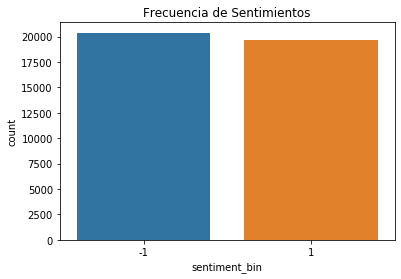

In [13]:
# Ahora verificamos la frecuencia de los sentimientos refactorizados
sns.countplot(df['sentiment_bin'])
plt.title('Frecuencia de Sentimientos')
plt.show()

## Feature Engineering

In [14]:
# ahora refactorizaremos el contenido de los twits para no considerar palabras no representativas
stopwords = nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hugopriest/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hugopriest/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
# limpiamos la columna content de caracteres extraños 
df['content']=df['content'].map(lambda x:re.sub(r"(?:\@|https?\://)\S+", "",x))
df['content'].sample(5)

30540                        yay! i love new ppl! wooooo!!
21744                           that would be awesome  lol
18092                              i'd just plain go crazy
3897     this is horrible. lauren cant go out no more. ...
35255     yeah, but mr. mom's i would say, appreciate t...
Name: content, dtype: object

In [16]:
# para lemantización utilizaremos la siguiente lógica
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download('punkt')

def tokenizador(contenido):
    ps=nltk.stem.PorterStemmer()
    stop_words = set(stopwords.words('english')) 
    temp=word_tokenize(contenido)
    filtro=[w for w in temp if not w in stop_words]
    stemmed=''
    for i in filtro:
        if i!=filtro[-1]:
            stemmed+=ps.stem(i)+' '
        else:
            stemmed += ps.stem(i)
    return stemmed

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hugopriest/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
df['content_token']=df['content'].apply(tokenizador)
df.loc[:,('content','content_token')].sample(5)

content  \
39316  got an re exam on tuesday. wish me luck / pray...   
39007   hmm, tasty!  going to have curry rice with pe...   
33910  it feels like its nine and not one. guess what...   
23995   haha!! someone with an axe just popped up at ...   
31152  frenchieb-day #frenchieb-day #frenchieb-day #f...   

                                           content_token  
39316  got exam tuesday . wish luck / pray ? thank . xxx  
39007      hmm , tasti ! go curri rice pea probabl . ; )  
33910       feel like nine one . guess ? love make money  
23995              haha ! ! someon axe pop sceni ! ! ???  
31152  frenchieb-day# frenchieb-day# frenchieb-day# f...

In [18]:
#contar ocurrencias 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [19]:
# instancio el objeto
TfidfV = TfidfVectorizer(stop_words='english', max_features=1000) 
# aplico fit_transform
TfidfV_fit = TfidfV.fit_transform(df['content_token'])
# extraigo los tokens
words = TfidfV.get_feature_names()
# extraigo la frecuencia por palabras
words_frec = TfidfV_fit.toarray().sum(axis=0)
# genero un datagrame
df_words = pd.DataFrame({'words':words, 'words_frecuencia':words_frec})
df_words = df_words.sort_values(by='words_frecuencia', ascending=False)

In [20]:
df_words.head(5)

words  words_frecuencia
225    day       1029.154601
362   good        777.491345
968   work        769.777931
528   love        714.972951
860  thank        667.281483

In [21]:
def get_frec_by_token(df, var='lyrics', vectorizer=CountVectorizer, max_features=1000):
    """
    Recibe un dataframe y entrega la frecuencia de las palabras.
    """
    # instancio el objeto
    vector=vectorizer(stop_words='english', max_features=max_features)
    # defino el vector que contiene los tokens
    token = df[var]
    # aplico fit_transform
    vector_fit = vector.fit_transform(token)
    # genero los token (palabras)
    words = vector.get_feature_names()
    # genero la frecuencia de cada token
    words_freq = vector_fit.toarray().sum(axis=0)
    # genero un dataframe
    df_freq = pd.DataFrame(data=words_freq, index=words, columns=['frecuencia'])
    # retorno el dataframe ordenado por frecuencia
    return df_freq.sort_values(by='frecuencia', ascending=False)

In [22]:
df_words2 = get_frec_by_token(df=df, var='content_token', vectorizer=TfidfVectorizer)

In [23]:
df_words2.head(5)

frecuencia
day    1029.154601
good    777.491345
work    769.777931
love    714.972951
thank   667.281483

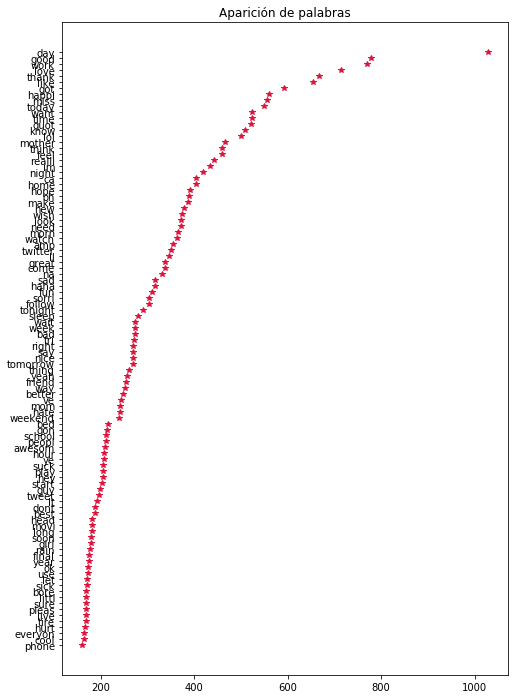

In [24]:
# Revisamos las 100 palabras con mayor frecuencia catalogadas por positivas o negativas
var = df_words2['frecuencia'].head(100).sort_values()
plt.figure(figsize=(8,12))
plt.plot(var, list(var.index), '*', color='crimson')
plt.title('Aparición de palabras');

## Modelación